# Calculation of spring bloom NCP (bNCP) from nitrate drawdown
#### Contents:
1. Importing packages and setting directories
2. Loading in a single float file
3. Exploring the data
    - Plotting the float track
    - Section plots
4. Mixed layer means

----
Seth Bushinsky - Dec. 2025

# 1. Setting up your notebook: packages and directories
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import os
# import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from scipy import stats
# from tqdm import tqdm
import xarray as xr
import gsw 

In [2]:
# Set directories
base_dir = "/Users/sethbushinsky/"

# I store my data and code  in separate directories, adjust as needed
data_dir = base_dir + "UHM_Ocean_BGC_Group Dropbox/Datasets/"
argo_path = data_dir + "Data_Products/BGC_ARGO_GLOBAL/2025_01_24/processed/for_external_sharing/"
glodap_path = data_dir + "Data_Products/GLODAP/"

# path for saving figures, etc
home_dir = base_dir + "UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/"
figure_dir = home_dir + "Projects/2025_10_BGC_Argo_Plus_Code_examples/plots/"
plot_ver = 'v_1'

# 2. Loading an Argo file and examine its contents
--- 
Let's try to reproduce Plant et al. 2016's numbers. Download 1 or more of these floats here: https://www.bgc-argo-plus.info/float_meta_table/ or access the ftp site directly here: https://ftp.soest.hawaii.edu/bgc_argo_plus/Individual_Floats/outliers_removed/


5902128, 5903274, 5903405, 5903714, 5903891, 5904125. 

In [3]:
# Choose the float file you want to plot:
float_file = '5902128_Sprof_BGCArgoPlus.nc'

# load the file and explore the data
argo_n = xr.open_dataset(argo_path + float_file) 
argo_n

<xarray.Dataset> Size: 28MB
Dimensions:                            (N_PROF: 216, N_PARAM: 5, N_CALIB: 1,
                                        N_LEVELS: 548)
Coordinates:
    JULD                               (N_PROF) datetime64[ns] 2kB ...
    LATITUDE                           (N_PROF) float64 2kB ...
    LONGITUDE                          (N_PROF) float64 2kB ...
    PRES_ADJUSTED_BGCArgoPlus          (N_PROF, N_LEVELS) float32 473kB ...
  * N_LEVELS                           (N_LEVELS) int64 4kB 0 1 2 ... 546 547
  * N_PROF                             (N_PROF) int64 2kB 0 1 2 ... 213 214 215
Dimensions without coordinates: N_PARAM, N_CALIB
Data variables: (12/86)
    DATA_TYPE                          object 8B ...
    FORMAT_VERSION                     object 8B ...
    HANDBOOK_VERSION                   object 8B ...
    REFERENCE_DATE_TIME                object 8B ...
    DATE_CREATION                      object 8B ...
    DATE_UPDATE                        object 8B ...
    ...                                 ...
    spiciness0                         (N_PROF, N_LEVELS) float64 947kB ...
    cons_temp                          (N_PROF, N_LEVELS) float64 947kB ...
    gamma                              (N_PROF, N_LEVELS) float64 947kB ...
    depth                              (N_PROF, N_LEVELS) float64 947kB ...
    MLD                                (N_PROF) float64 2kB ...
    DOXY_SAT                           (N_PROF, N_LEVELS) float64 947kB ...
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2024-12-18T06:05:20Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

# 3. Take a first look at the data
---
To do this we will use the Cartopy package, which has handy geographic plotting functions. A few things to keep in mind when dealing with spatial plots:

- Longitude conventions (-180/180 or 0/360). Both are commonly used, but some packages accept only one.

- Projections: The projection is how a set of coordinates is displayed on a map - basically how do you display data from an oblate spheroid (the Earth) onto a flat screen. There are many projections out there, right now I'm a fan of Interrupted Goode Homolosime projectsion (see below). 

- Data Projection vs. Map Projection. Cartopy needs you to pass a simple lat/lon projection type (PlateCarree shown below) for your data, while your map Projection can be anything you choose. I mention this because if you use the map projection for both your data "transform" and your map projection, your data will not show up in the correct place. I've done this enough that I assume others will make the same mistake.

Text(0.5, 1.0, 'Float 5902128 Track')

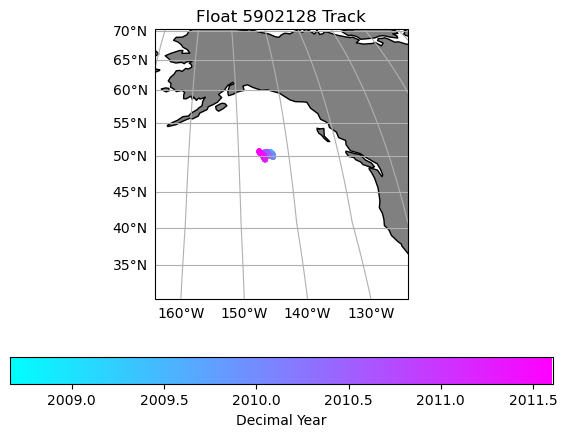

In [4]:
# First let's make a map of the figure track so we know where it is: 

# For plotting it will be easier if we create a time variable in decimal years
argo_n['decimal_year'] = (['N_PROF'],np.empty(argo_n.PRES_ADJUSTED.shape[0])) # add an empty variable 
argo_n.decimal_year[:] = np.nan # set all values to nan
date_time = pd.to_datetime(argo_n.JULD.values) # get out the time, converted to a Pandas datetime
year = date_time.year # extract the year
decimal_year = year + (date_time.day_of_year - 1) / 365.25 # extract the day of year, convert to decimal year and add the year
argo_n.decimal_year[:] = decimal_year # save into the array. This step isn't really necessary here, but keeps things organized and you could save it out for later use. I should probably just add decimal year to the files..

data_proj = ccrs.PlateCarree(central_longitude=0)
median_lon = np.nanmedian(argo_n['LONGITUDE'].values)
median_lat = np.nanmedian(argo_n['LATITUDE'].values)
map_proj =ccrs.InterruptedGoodeHomolosine(central_longitude=median_lon, globe=None, emphasis='ocean')

fig = plt.figure(figsize=(7,5))

ax0 = fig.add_subplot(1,1,1, projection=map_proj)
ax0.set_global()
ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor=[.5, .5 ,.5]))

map = ax0.scatter(argo_n.LONGITUDE.values, argo_n.LATITUDE.values, s=10, c=argo_n.decimal_year, transform=data_proj, cmap='cool')
lat_lon_padding = 20
ax0.set_extent([median_lon-lat_lon_padding, median_lon+lat_lon_padding, median_lat-lat_lon_padding, median_lat+lat_lon_padding], crs=data_proj)
# # add lat/lon gridlines and labels
gl = ax0.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
plt.colorbar(map, label='Decimal Year', orientation='horizontal')
plt.title('Float ' + str(argo_n['WMO_ID'].values) + ' Track')


## Section plots
---

In [5]:
# While we should have the variables we want, since we picked our float file, let's double check that everything is there and has some valid data:

var_suffix = '_ADJUSTED_BGCArgoPlus'
pres_name = 'PRES' + var_suffix
vars_to_plot_all = ['TEMP' + var_suffix, 'NITRATE' + var_suffix, 'DOXY' + var_suffix, 'CHLA' + var_suffix, 'BBP700' + var_suffix]
vars_to_plot = []
# check that these variables exist in the float file and have valid data:
for var in vars_to_plot_all:
    if var not in argo_n.variables:
        print(f"Variable {var} not found in dataset.")
    elif np.all(np.isnan(argo_n[var].values)):
        print(f"Variable {var} contains only NaN values.")
    else:
        vars_to_plot.append(var)
    
print("Variables to plot:", vars_to_plot)

Variable CHLA_ADJUSTED_BGCArgoPlus not found in dataset.
Variable BBP700_ADJUSTED_BGCArgoPlus not found in dataset.
Variables to plot: ['TEMP_ADJUSTED_BGCArgoPlus', 'NITRATE_ADJUSTED_BGCArgoPlus', 'DOXY_ADJUSTED_BGCArgoPlus']


Text(0.5, 0.98, 'Float 5902128')

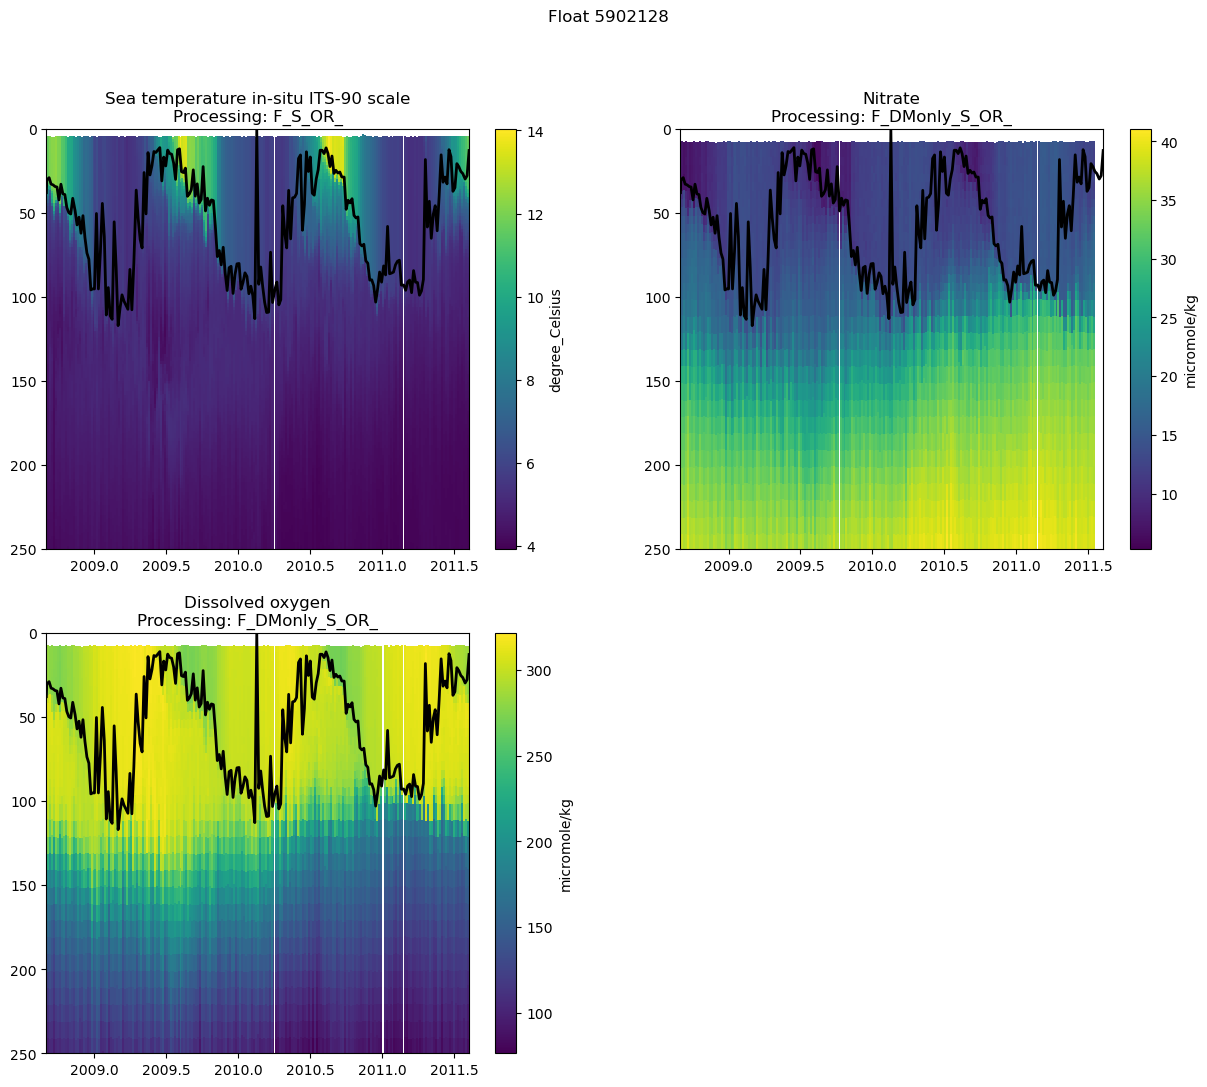

In [6]:
max_depth = 250 # we're interested in the upper ocean, so let's limit our figures to that depth
# We'll also overlay the MLD since that will be important for our analysis
color_map = 'viridis'
num_rows = int(np.ceil((len(vars_to_plot))/2))
fig = plt.figure(figsize=(15, 6*num_rows))

plot_num = 0

for var_name in vars_to_plot:
    plot_num += 1
    ax2 = fig.add_subplot(num_rows,2,plot_num)

    if ~np.all(np.isnan(argo_n[var_name])):
        var_min = np.nanmin(argo_n[var_name].where(argo_n[pres_name]<=max_depth))
        var_max = np.nanmax(argo_n[var_name].where(argo_n[pres_name]<=max_depth))    

    for p in range(0, len(argo_n.N_PROF)):
        # p_p = argo_n[pres_name][p, ~np.isnan(argo_n[pres_name][p,:])].values
        t_p = np.array([argo_n.decimal_year[p].item(), argo_n.decimal_year[p].values + np.nanmedian(np.diff(argo_n.decimal_year))]) # try padding with median difference between profile times instead of next profile in case of large gaps

        # t_p = argo_n.decimal_year[p:p+2].values
        if t_p.size==1:
            t_p = np.tile(t_p, (2,1))
            t_p[1] = t_p[1] + (argo_n.decimal_year[p] - argo_n.decimal_year[p-1]).values
        elif np.isnan(t_p).any(): # if any values in t_p are nans
            if np.isnan(t_p).all(): # if all are nans, continue
                continue
            elif np.isnan(t_p[0]):
                t_p[0] = t_p[1] - 10/365
            else:
                t_p[1] = t_p[0] + 10/365
        # xl,yl = np.meshgrid(t_p, p_p)

        # extracting the variable that we want to plot
        # c = argo_n[var_name][p,~np.isnan(argo_n[pres_name][p,:])].values

        # extracting the variable, this time removing any vertical gaps
        c2= argo_n[var_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
        
        # if c.size==0:
        #     continue
        # else:
        #     c = np.tile(c, (2,1))
        #     c = c.T
        #     pc = ax.pcolormesh(xl, yl, c[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)
       
        # we'll need a different shape x/y array to match the size of c2 (it is likely smaller in the vertical direction due to removed gaps)
        if c2.size==0:
            continue
        else:
            p_p2 = argo_n[pres_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
            xl2, yl2 = np.meshgrid(t_p, p_p2)

            c2 = np.tile(c2, (2,1))
            c2 = c2.T

            pc2 = ax2.pcolormesh(xl2, yl2, c2[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)

      
    ax2.plot(argo_n.decimal_year, argo_n['MLD'].values, 'k-', linewidth=2)
    # cl1 = plt.colorbar(pc, ax=ax)
    # ax.set_ylim(argo_n[pres_name].max().values, 0)
    # ax.set_xlim(argo_n['decimal_year'][0], argo_n['decimal_year'][-1])
    # ax.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
    # cl1.set_label(f'{argo_n[var_name].standard_name} \n({argo_n[var_name].units})')

    cl2 = plt.colorbar(pc2, ax=ax2)
    ax2.set_ylim(max_depth, 0)
    ax2.set_xlim(argo_n['decimal_year'][0], argo_n['decimal_year'][-1])
    ax2.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
    cl2.set_label(f'{argo_n[var_name].units}')

fig.suptitle(f"Float {argo_n['WMO_ID'].values}")
# fig.savefig(figure_dir + f"Float_{argo_n['WMO_ID'].values}_BGCArgoPlus_Section_Plots_{plot_ver}.png", dpi=300)

# print(f"Figure saved to {figure_dir}, with the filename: Float_{argo_n['WMO_ID'].values}_BGCArgoPlus_Section_Plots_{plot_ver}.png")

This float looks promising, let's pick just one "float-year" and look more closely at the seasonal cycle.

I'm going to copy the cell above and zoom in on a specific time range. While I'm at it I'm going to manually specify color ranges so that the upper ocean features stand out in all variables. **You should modify your time range, max depth, and variable ranges to better show your own float's data.**

Text(0.5, 0.98, 'Float 5902128')

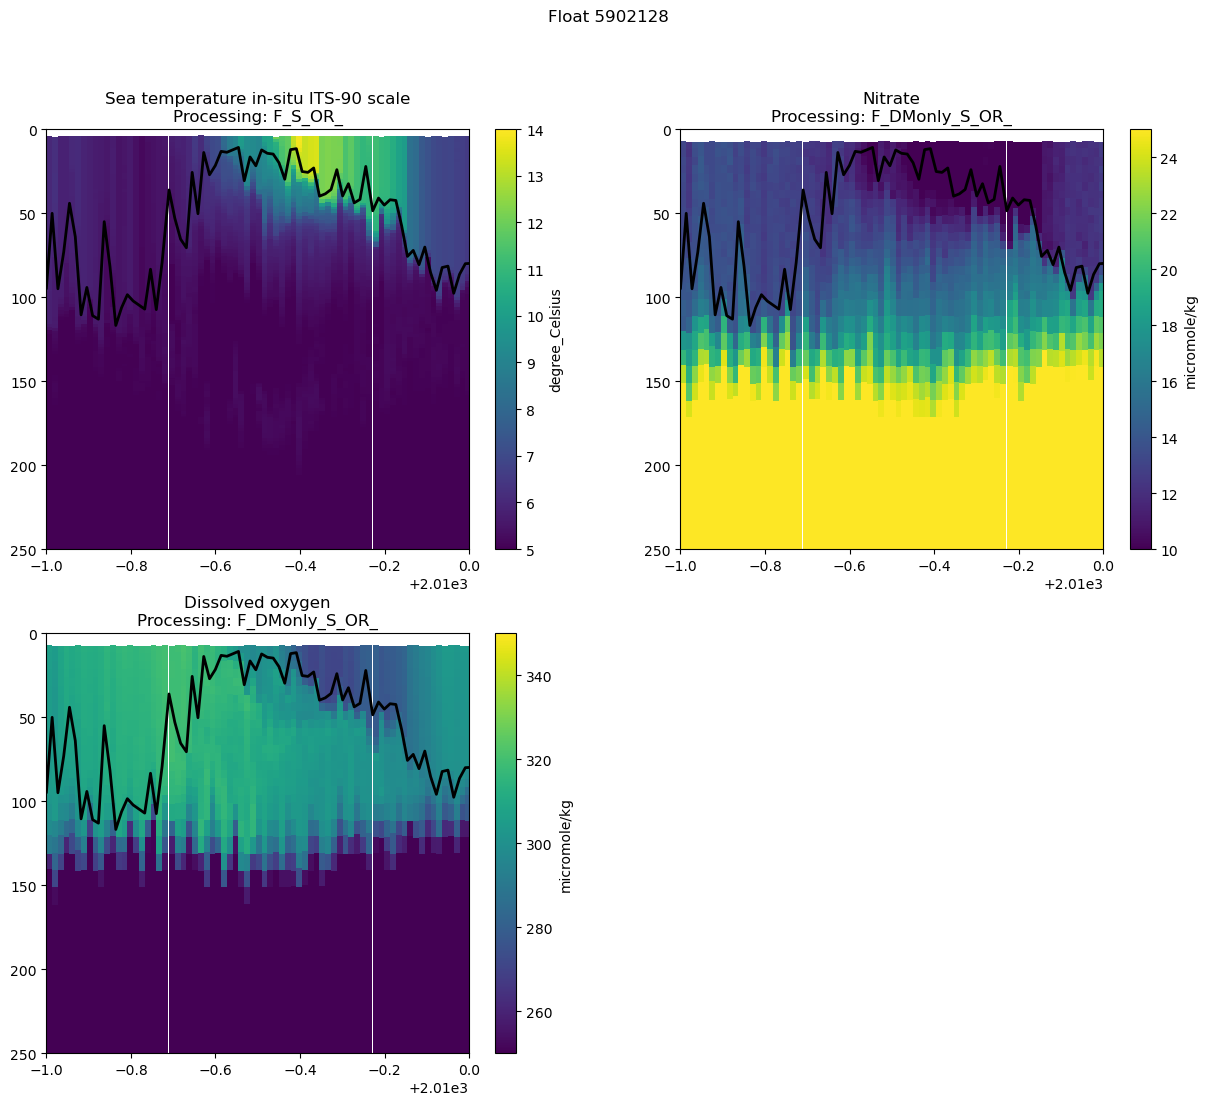

In [7]:
min_time = 2009 
max_time = 2010 # plotting a bit over 1 year so that I have a better reference for what is going on

var_min_max = {'TEMP' + var_suffix: (5,14),
               'NITRATE' + var_suffix: (10, 25),
               'DOXY' + var_suffix: (250, 350),
               'CHLA' + var_suffix: (0, 0.3),
               'BBP700' + var_suffix: (0, 0.001)}

max_depth = 250 # we're interested in the upper ocean, so let's limit our figures to that depth
# We'll also overlay the MLD since that will be important for our analysis

num_rows = int(np.ceil((len(vars_to_plot))/2))
fig = plt.figure(figsize=(15, 6*num_rows))

plot_num = 0

for var_name in vars_to_plot:
    plot_num += 1
    ax2 = fig.add_subplot(num_rows,2,plot_num)

    if ~np.all(np.isnan(argo_n[var_name])):
        var_min = var_min_max[var_name][0]
        var_max = var_min_max[var_name][1]

    for p in range(0, len(argo_n.N_PROF)):
        # p_p = argo_n[pres_name][p, ~np.isnan(argo_n[pres_name][p,:])].values
        t_p = np.array([argo_n.decimal_year[p].item(), argo_n.decimal_year[p].values + np.nanmedian(np.diff(argo_n.decimal_year))]) # try padding with median difference between profile times instead of next profile in case of large gaps

        # t_p = argo_n.decimal_year[p:p+2].values
        if t_p.size==1:
            t_p = np.tile(t_p, (2,1))
            t_p[1] = t_p[1] + (argo_n.decimal_year[p] - argo_n.decimal_year[p-1]).values
        elif np.isnan(t_p).any(): # if any values in t_p are nans
            if np.isnan(t_p).all(): # if all are nans, continue
                continue
            elif np.isnan(t_p[0]):
                t_p[0] = t_p[1] - 10/365
            else:
                t_p[1] = t_p[0] + 10/365
        # xl,yl = np.meshgrid(t_p, p_p)

        # extracting the variable that we want to plot
        # c = argo_n[var_name][p,~np.isnan(argo_n[pres_name][p,:])].values

        # extracting the variable, this time removing any vertical gaps
        c2= argo_n[var_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
        
        # if c.size==0:
        #     continue
        # else:
        #     c = np.tile(c, (2,1))
        #     c = c.T
        #     pc = ax.pcolormesh(xl, yl, c[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)
       
        # we'll need a different shape x/y array to match the size of c2 (it is likely smaller in the vertical direction due to removed gaps)
        if c2.size==0:
            continue
        else:
            p_p2 = argo_n[pres_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
            xl2, yl2 = np.meshgrid(t_p, p_p2)

            c2 = np.tile(c2, (2,1))
            c2 = c2.T

            pc2 = ax2.pcolormesh(xl2, yl2, c2[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)

      
    ax2.plot(argo_n.decimal_year, argo_n['MLD'].values, 'k-', linewidth=2)
    # cl1 = plt.colorbar(pc, ax=ax)
    # ax.set_ylim(argo_n[pres_name].max().values, 0)
    # ax.set_xlim(argo_n['decimal_year'][0], argo_n['decimal_year'][-1])
    # ax.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
    # cl1.set_label(f'{argo_n[var_name].standard_name} \n({argo_n[var_name].units})')

    cl2 = plt.colorbar(pc2, ax=ax2)
    ax2.set_ylim(max_depth, 0)
    ax2.set_xlim(min_time, max_time)
    ax2.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
    cl2.set_label(f'{argo_n[var_name].units}')

fig.suptitle(f"Float {argo_n['WMO_ID'].values}")
# fig.savefig(figure_dir + f"Float_{argo_n['WMO_ID'].values}_BGCArgoPlus_Section_Plots_{plot_ver}.png", dpi=300)

# print(f"Figure saved to {figure_dir}, with the filename: Float_{argo_n['WMO_ID'].values}_BGCArgoPlus_Section_Plots_{plot_ver}.png")

# Signals of production

What do we expect to see if there is production? Where should we see changes in nitrate, oxygen, CHLA or Backscatter?

What are the important fluxes to expect for nitrate and oxygen? What would we need to know to calculate production from these data?

Let's add some boxes onto these figures to help us think through the changes we would expect over time. We'll choose three time points: t0, t1, and t2, which should correspond to when the mixed layer first shoals, when it first starts to deepen, and when it is at its maximum depth

Text(0.5, 0.98, 'Float 5902128')

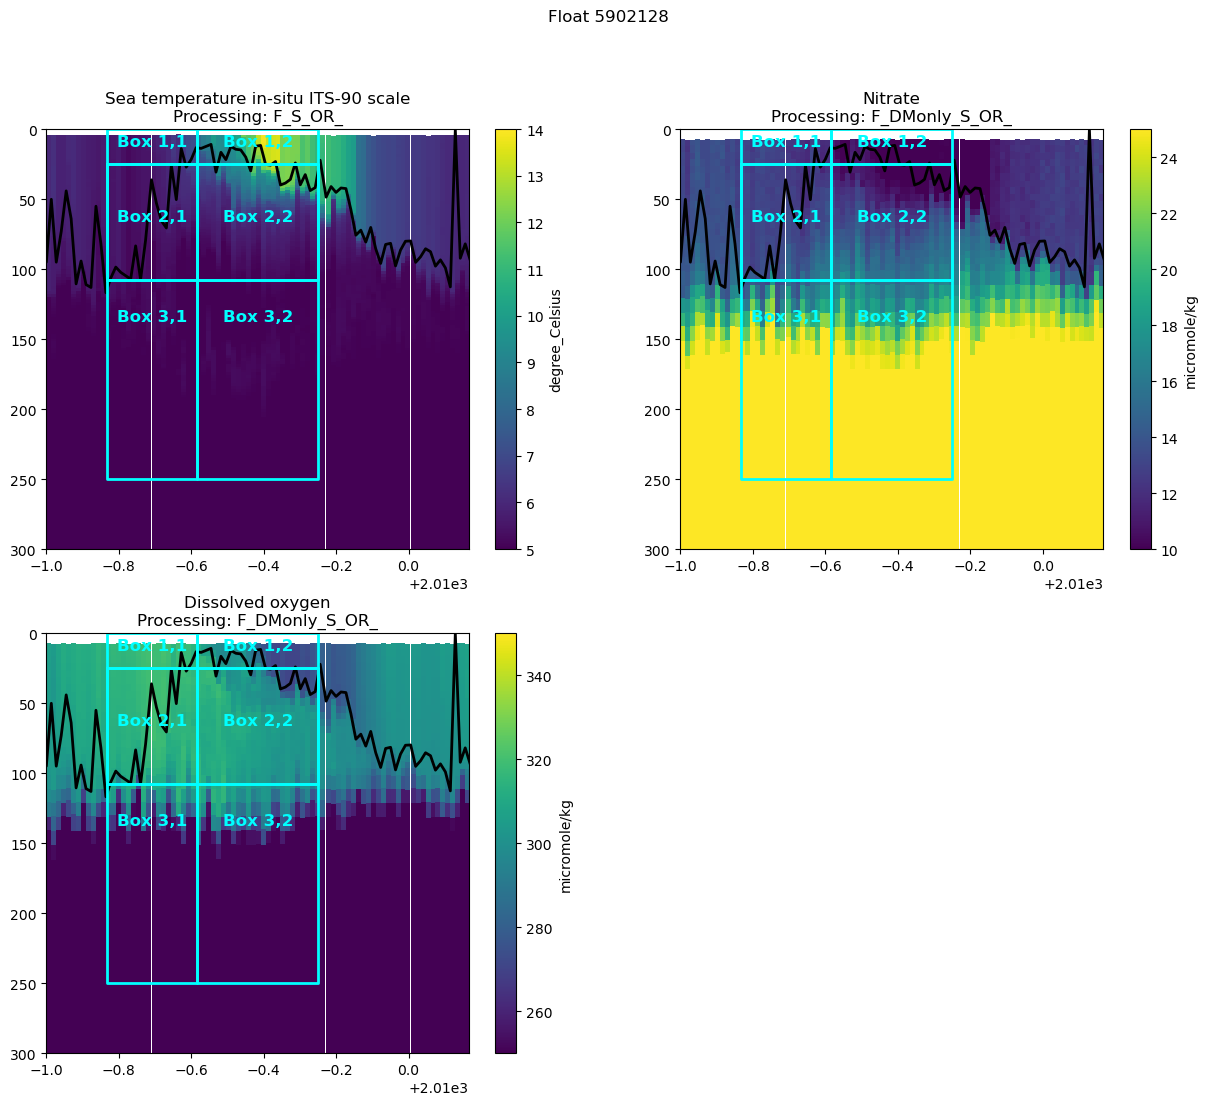

In [9]:
# You'll probably have to adjust these time periods iteratively until you get something that looks good for your float data
t0 = 2009 +2/12
t1 = 2009 + 5/12
t2 = 2009 + 9/12

# we'll set our box depths according the the MLDs during those time periods and a deeper depth for the box below the maximum winter MLD
MLD1 =  argo_n['MLD'].where((argo_n.decimal_year>=t0) & (argo_n.decimal_year<t1) ).max().values # argo_n['MLD'].where((argo_n.decimal_year>=t0) & (argo_n.decimal_year<t1) ).mean().values
MLD2 = argo_n['MLD'].where((argo_n.decimal_year>=t1) & (argo_n.decimal_year<t2) ).mean().values
max_box_depth = 250
max_depth = 300 # we'll extend the depth of our plot so that we can see the maximum box depth

vars_to_plot = ['TEMP' + var_suffix, 'NITRATE' + var_suffix, 'DOXY' + var_suffix] # I'm going to focus on T, N, and O2 for now
min_time = t0-2/12 #2019 + 6/12
max_time = t2 + 5/12 # 2021 # plotting a bit over 1 year so that I have a better reference for what is going on

# var_min_max = {'TEMP' + var_suffix: (17,25),
#                'NITRATE' + var_suffix: (1, 4),
#                'DOXY' + var_suffix: (200, 235),
#                'CHLA' + var_suffix: (0, 0.3),
#                'BBP700' + var_suffix: (0, 0.001)}

# We'll also overlay the MLD since that will be important for our analysis

num_rows = int(np.ceil((len(vars_to_plot))/2))
fig = plt.figure(figsize=(15, 6*num_rows))

plot_num = 0



for var_name in vars_to_plot:
    plot_num += 1
    ax2 = fig.add_subplot(num_rows,2,plot_num)

    if ~np.all(np.isnan(argo_n[var_name])):
        var_min = var_min_max[var_name][0]
        var_max = var_min_max[var_name][1]

    for p in range(0, len(argo_n.N_PROF)):
        # p_p = argo_n[pres_name][p, ~np.isnan(argo_n[pres_name][p,:])].values
        t_p = np.array([argo_n.decimal_year[p].item(), argo_n.decimal_year[p].values + np.nanmedian(np.diff(argo_n.decimal_year))]) # try padding with median difference between profile times instead of next profile in case of large gaps

        # t_p = argo_n.decimal_year[p:p+2].values
        if t_p.size==1:
            t_p = np.tile(t_p, (2,1))
            t_p[1] = t_p[1] + (argo_n.decimal_year[p] - argo_n.decimal_year[p-1]).values
        elif np.isnan(t_p).any(): # if any values in t_p are nans
            if np.isnan(t_p).all(): # if all are nans, continue
                continue
            elif np.isnan(t_p[0]):
                t_p[0] = t_p[1] - 10/365
            else:
                t_p[1] = t_p[0] + 10/365
        # xl,yl = np.meshgrid(t_p, p_p)

        # extracting the variable that we want to plot
        # c = argo_n[var_name][p,~np.isnan(argo_n[pres_name][p,:])].values

        # extracting the variable, this time removing any vertical gaps
        c2= argo_n[var_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
        
        # if c.size==0:
        #     continue
        # else:
        #     c = np.tile(c, (2,1))
        #     c = c.T
        #     pc = ax.pcolormesh(xl, yl, c[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)
       
        # we'll need a different shape x/y array to match the size of c2 (it is likely smaller in the vertical direction due to removed gaps)
        if c2.size==0:
            continue
        else:
            p_p2 = argo_n[pres_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
            xl2, yl2 = np.meshgrid(t_p, p_p2)

            c2 = np.tile(c2, (2,1))
            c2 = c2.T

            pc2 = ax2.pcolormesh(xl2, yl2, c2[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)

      
    ax2.plot(argo_n.decimal_year, argo_n['MLD'].values, 'k-', linewidth=2)

    # t1 boxes
    ax2.plot([t0, t1, t1, t0, t0], [MLD1, MLD1, 0 , 0, MLD1], '-', color='cyan', linewidth=2)
    ax2.plot([t0, t1, t1, t0, t0], [MLD2, MLD2, MLD1, MLD1, MLD2], '-', color='cyan', linewidth=2)
    ax2.plot([t0, t1, t1, t0, t0], [MLD2, MLD2, max_box_depth , max_box_depth, MLD2], '-', color='cyan', linewidth=2)

     # t2 boxes
    ax2.plot([t1, t2, t2, t1, t1], [MLD1, MLD1, 0 , 0, MLD1], '-', color='cyan', linewidth=2)
    ax2.plot([t1, t2, t2, t1, t1], [MLD2, MLD2, MLD1, MLD1, MLD2], '-', color='cyan', linewidth=2)
    ax2.plot([t1, t2, t2, t1, t1], [MLD2, MLD2, max_box_depth , max_box_depth, MLD2], '-', color='cyan', linewidth=2)

    # label the boxes 
    ax2.text((t0 + t1)/2, MLD2/2, 'Box 1,1', color='cyan', fontsize=12, fontweight='bold', ha='center')
    ax2.text((t1 + t2)/2, MLD2/2, 'Box 1,2', color='cyan', fontsize=12, fontweight='bold', ha='center')
    ax2.text((t0 + t1)/2, (MLD2-MLD1)/2+MLD1, 'Box 2,1', color='cyan', fontsize=12, fontweight='bold', ha='center')
    ax2.text((t1 + t2)/2, (MLD2-MLD1)/2+MLD1, 'Box 2,2', color='cyan', fontsize=12, fontweight='bold', ha='center')

    ax2.text((t0 + t1)/2, (max_box_depth-MLD2)/2+MLD2, 'Box 3,1', color='cyan', fontsize=12, fontweight='bold', ha='center')
    ax2.text((t1 + t2)/2, (max_box_depth-MLD2)/2+MLD2, 'Box 3,2', color='cyan', fontsize=12, fontweight='bold', ha='center')


    cl2 = plt.colorbar(pc2, ax=ax2)
    ax2.set_ylim(max_depth, 0)
    ax2.set_xlim(min_time, max_time)
    ax2.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
    cl2.set_label(f'{argo_n[var_name].units}')
    
fig.suptitle(f"Float {argo_n['WMO_ID'].values}")
# fig.savefig(figure_dir + f"Float_{argo_n['WMO_ID'].values}_BGCArgoPlus_Section_Plots_{plot_ver}.png", dpi=300)

# print(f"Figure saved to {figure_dir}, with the filename: Float_{argo_n['WMO_ID'].values}_BGCArgoPlus_Section_Plots_{plot_ver}.png")

1. Write out the mass balance equations for these 3 boxes. What sign / 1st order changes in each tracer do you expect to see in each box?
2. Calculate the back of the envelope NCP in each box from nitrate and oxygen
    - What is different between the two? What would we need to account for with oxygen that we don't need to for nitrate? How would you expect that to change your nitrate calculation? 
3. Compare your answers to the groups with the other floats and to Plant et al. 2016 - how do they differ? 
4. Do you see any discernible signal in your deepest box? If you have time, try to add a diapycnal diffusivity flux and see if that helps

In [ ]:
# Finding nitrate concentrations in the different boxes
t0_1 = argo_n['NITRATE_ADJUSTED_BGCArgoPlus'].where((argo_n['decimal_year']>=t0) &  (argo_n['decimal_year']<t1))
t1_2 = argo_n['NITRATE_ADJUSTED_BGCArgoPlus'].where((argo_n['decimal_year']>=t1) &  (argo_n['decimal_year']<t2))

box_11_mask = t0_1['PRES_ADJUSTED_BGCArgoPlus']<MLD2
box_12_mask = (t0_1['PRES_ADJUSTED_BGCArgoPlus']>=MLD2) & (t0_1['PRES_ADJUSTED_BGCArgoPlus']<MLD1)
box_13_mask = (t0_1['PRES_ADJUSTED_BGCArgoPlus']>=MLD1) & (t0_1['PRES_ADJUSTED_BGCArgoPlus']<max_box_depth)

box_21_mask = t1_2['PRES_ADJUSTED_BGCArgoPlus']<MLD2
box_22_mask = (t1_2['PRES_ADJUSTED_BGCArgoPlus']>=MLD2) & (t1_2['PRES_ADJUSTED_BGCArgoPlus']<MLD1)
box_23_mask = (t1_2['PRES_ADJUSTED_BGCArgoPlus']>=MLD1) & (t1_2['PRES_ADJUSTED_BGCArgoPlus']<max_box_depth)


box_11_no3 = t0_1.where(box_11_mask).mean().values
box_12_no3 = t0_1.where(box_12_mask).mean().values
box_13_no3 = t0_1.where(box_13_mask).mean().values
print(f'box 11 no3: {box_11_no3:.2f}, box 12 no3: {box_12_no3:.2f}, box 13 no3: {box_13_no3:.2f}')

box_21_no3 = t1_2.where(box_21_mask).mean().values
box_22_no3 = t1_2.where(box_22_mask).mean().values
box_23_no3 = t1_2.where(box_23_mask).mean().values
print(f'box 21 no3: {box_21_no3:.2f}, box 22 no3: {box_22_no3:.2f}, box 23 no3: {box_23_no3:.2f}')
print(f'MLDs: {MLD2}, {MLD1}')

box 11 no3: 12.51, box 12 no3: 13.32, box 13 no3: 28.31
box 21 no3: 9.01, box 22 no3: 12.93, box 23 no3: 27.65
MLDs: 24.675, 107.44


In [ ]:
# calculate NCP from the nitrate changes between box 1 and box 2
d_yr = (t1+t2)/2 - (t0+t1)/2 
d_t_days = d_yr*365.25

box_1_ncp = (box_11_no3 - box_21_no3)*1025*1e-6*MLD2 / d_t_days * 106/16 # umol / kg * kg/m3 * mol/umol * m / days * 106C / 16N
box_1_ncp_mmol_m2_d = box_1_ncp*1000
print(f'NCP in mmol C m-2 d-1: {box_1_ncp_mmol_m2_d:.2f}' )

Text(0, 0.5, 'Our estimates, mol C /m2 /yr')

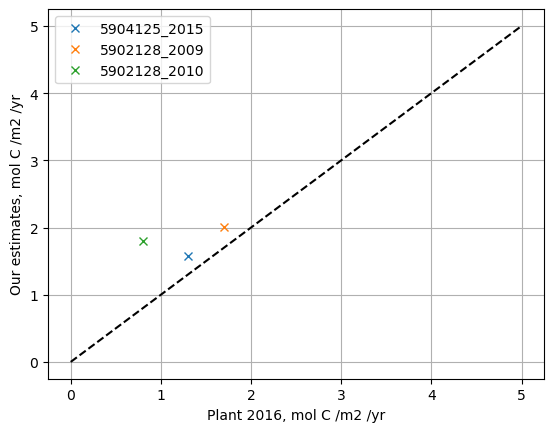

In [39]:
# comparison of group calculations to Plant et al. 

f5904125_2015 = [4.3*365/1000, 1.3]
f5902128_2009 = [5.5*365/1000, 1.7]
f5902128_2010 = [1.8, 0.8]

plt.plot(f5904125_2015[1], f5904125_2015[0], 'x', label='5904125_2015')
plt.plot(f5902128_2009[1], f5902128_2009[0], 'x', label='5902128_2009')
plt.plot(f5902128_2010[1], f5902128_2010[0], 'x', label='5902128_2010')
plt.grid('on')
plt.plot([0, 5], [0,5], '--k')
plt.legend()
plt.xlabel('Plant 2016, mol C /m2 /yr')
plt.ylabel('Our estimates, mol C /m2 /yr')
